## Error and Correlation from all 3 models for top 5 images

In [2]:
# ## Uncomment if using Google Colab and upload file dataTop50.xlsx
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
# Initialize these:
# typeImg = "top" # photo/ cartoon/ all"
# numImg = "50" # 5 or 50
# sz = 100
filepath = 'dataTop50.xlsx'
strtInd = [0, 2900, 5800, 8700, 11600, 14500, 17400, 20300, 23200, 26100, 29000, 31900, 34800]

In [4]:
 # Include imports
import glob
from skimage.transform import resize
from skimage.io import imread, imsave, imshow
import os
import pandas as pd
import numpy as np
import skimage.color as skcolor
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
colNames = ["col_"+str(i) for i in range(58)] 
allConcepts = ['mango','watermelon','honeydew','cantaloupe','grapefruit','strawberry','raspberry','blueberry','avocado','orange','lime','lemon']

# Read data
# Get the color ratings data -From file data_clean.csv
data = pd.read_csv("data_clean.csv",names = colNames)

# Get the LAB coordinates of colors from file LabOrig.csv
#colorData = pd.read_csv("LabOrig.csv",header=None)
colorData = pd.read_csv("Lab.csv",header=None)
colorDataRGB = pd.read_csv("RGB.csv",header=None)
path = "E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads"
sz = 100

In [6]:
df = pd.read_excel(filepath)
Q = df.as_matrix()
Q.shape

(34800, 187)

In [7]:
Xfull = np.copy(Q[:,:-1])
Yfull = np.copy(Q[:,-1])
print(Xfull.shape, Yfull.shape)

(34800, 186) (34800,)


In [8]:
startInd = [0]
X = np.empty((0,186), float)
y = np.empty((0,), float)
for t in range(len(strtInd)-1):
    strt = strtInd[t]
    end = 5*58 + strt
    X = np.r_[X, Xfull[strt:end,:] ]
    y = np.r_[y, Yfull[strt:end]]
    startInd.append(len(X))
    
tempInd = np.copy(strtInd)
strtInd = np.copy(startInd)
print(X.shape)
print(strtInd)

(3480, 186)
[   0  290  580  870 1160 1450 1740 2030 2320 2610 2900 3190 3480]


In [9]:
# Function to computer error, correlation and rating for LOO fruit category 
# based on the features selected from Analysis (sparse regression)
from scipy import stats
        
def getRatings(minErrFeature):
    win0 = []
    win1 = []
    win2 = []
    xNew = np.column_stack([X[:,minErrFeature],y])
    correlation = []
    error = []

    # Linear Regression using Cross Validation
    # Leave one out cross validation -- strtInd holds the starting indices of set of fruit data 
    xTemp = np.copy(xNew)

    for i in range(len(strtInd)-1):
        # Leave one entire fruit group
        testFruit =  allConcepts[i]
        #print("\nLeaving out fruit group : ",allConcepts[i])
        testTemp = np.copy(xTemp[strtInd[i]:strtInd[i+1],:]) # Get all rows from the LOO group
        trainTemp = np.delete(xTemp,range(strtInd[i],strtInd[i+1]),0)
        row = len(trainTemp)
        #Training set
        X_train = np.column_stack([np.ones((row,1)), trainTemp[:,:-1]]) # add offset
        y_train = np.copy(trainTemp[:,-1])
        # Test set (hold out set)
        row2 = len(testTemp)
        X_test  = np.column_stack([np.ones((row2,1)), testTemp[:,:-1]]) #xTemp[row:tot,0:3]#
        y_test  = np.copy(testTemp[:,-1])


        # Create linear regression object
        regr = linear_model.LinearRegression(fit_intercept=False)
        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)
        print("Score is : %.2f" % regr.score(X_test, y_test))
        # The coefficients
        print('Coefficients: ', regr.coef_)
        #print('Intercept: \n', regr.intercept_)
        # The mean squared error
        print("\nMean squared error: %.4f"
              % mean_squared_error(y_test, y_pred))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % r2_score(y_test, y_pred))

        ############## For test purposes - Average prediction over all Images of LOO group ############
        totalTestImages = y_pred.size/58  #58N rows -> every image has 58 rows of data
        avg_pred = [np.sum([y_pred[p] for p in range(q,y_pred.size,58)])/totalTestImages for q in range(58)]

        # For Pearson correlation coefficient and the p-value (between avg_pred and true rating for fruit group)
        trueRating = np.copy(y_test[0:58])

        sqErr = np.sum(pow(avg_pred - trueRating,2))
        print("The true squared error (in color ratings) for left out fruit",testFruit,"is: %.4f" % sqErr)

        corrCoeff, pVal = stats.pearsonr(avg_pred, trueRating)
        print("\nPearson’s correlation coefficient (between true ratings and avg predicted ratings) is %.4f" %corrCoeff)
        print("p-value %.4f" %pVal)

        error.append(sqErr)
        correlation.append(corrCoeff)
        win0.append(corrCoeff) # saves correlation for test fruit
        win1.append(trueRating) # saves true rating for test fruit
        win2.append(avg_pred)   # saves avg predicted rating for test fruit
        # Plot average color rating over all test images.
        fig= plt.figure(figsize=(10,3))
        barPlot = plt.bar(range(1,59), avg_pred,color = colorDataRGB.values)
        plt.ylabel('Ratings')
        plt.xlabel('Colors')
        plt.title('Predicted color ratings for Fruit Group : %s' %testFruit)
        plt.xticks([i for i in range(1,59,3)],[i for i in range(1,59,3)])
        plt.ylim(0,1)
        plt.show()

        fig= plt.figure(figsize=(10,3))
        barPlot = plt.bar(range(1,59), trueRating,color = colorDataRGB.values)
        plt.ylabel('Ratings')
        plt.xlabel('Colors')
        plt.title('True color ratings for Fruit Group : %s' %testFruit)
        plt.xticks([i for i in range(1,59,3)],[i for i in range(1,59,3)])
        plt.ylim(0,1)
        plt.show()

        # Scatter plot
        fig2 = plt.figure(figsize=(7,7))
        plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
        plt.ylabel('Predicted Ratings')
        plt.xlabel('Subject Ratings')
        plt.title('Scatter plot of color ratings for : %s' %testFruit)
        plt.axis('equal')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.show() 
    return error, correlation, win0, win1, win2

# Regression on top 3 spherical features

Score is : 0.47
Coefficients:  [ 0.16368109  0.2183345  -0.14760913  0.25927324]

Mean squared error: 0.0179
Variance score: 0.47
The true squared error (in color ratings) for left out fruit mango is: 0.9598

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8572
p-value 0.0000


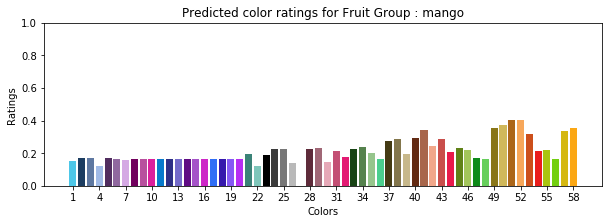

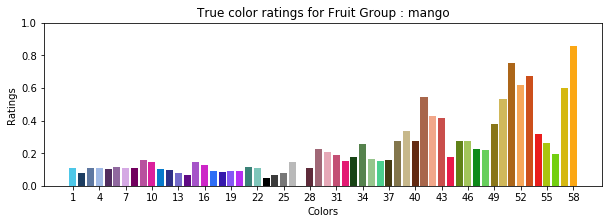

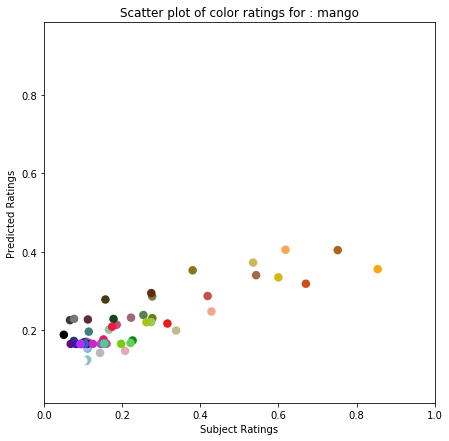

Score is : -0.09
Coefficients:  [ 0.1571738   0.29156572 -0.14371959  0.21754464]

Mean squared error: 0.0401
Variance score: -0.09
The true squared error (in color ratings) for left out fruit watermelon is: 2.1905

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.2016
p-value 0.1290


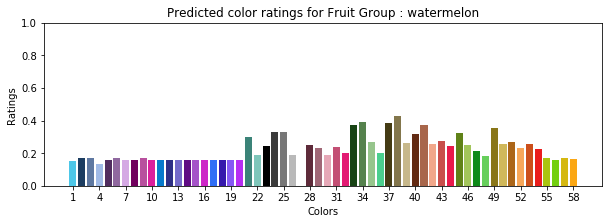

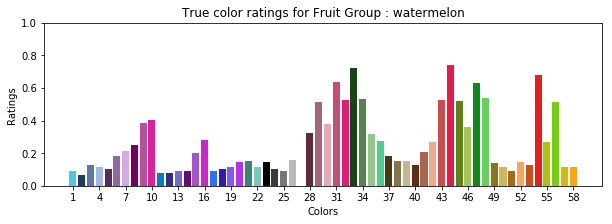

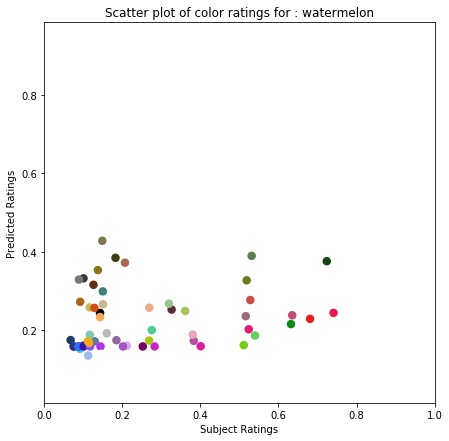

Score is : 0.46
Coefficients:  [ 0.16246028  0.26920347 -0.14162927  0.22819704]

Mean squared error: 0.0107
Variance score: 0.46
The true squared error (in color ratings) for left out fruit honeydew is: 0.5064

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7572
p-value 0.0000


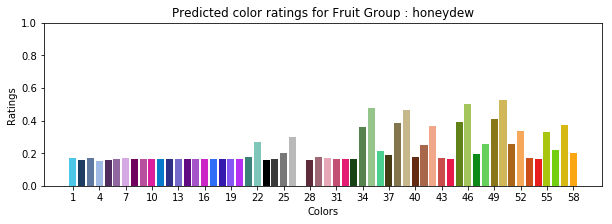

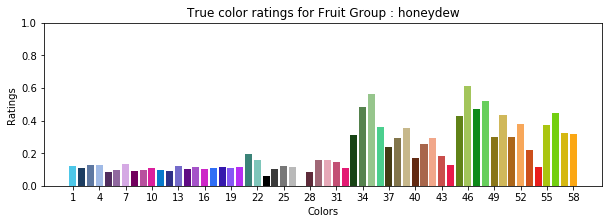

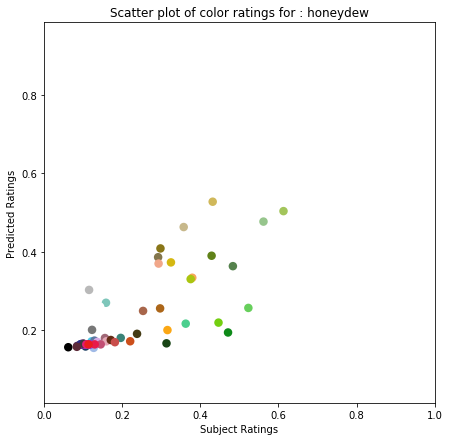

Score is : 0.49
Coefficients:  [ 0.16219605  0.25418396 -0.13617255  0.23509821]

Mean squared error: 0.0158
Variance score: 0.49
The true squared error (in color ratings) for left out fruit cantaloupe is: 0.7237

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7933
p-value 0.0000


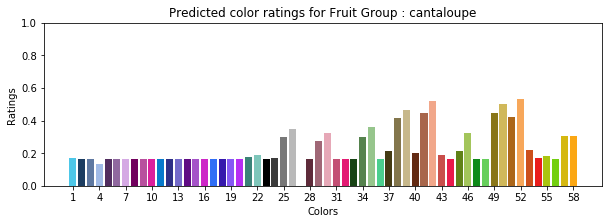

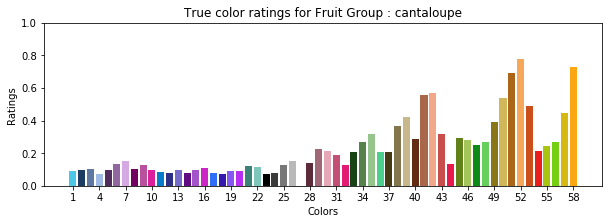

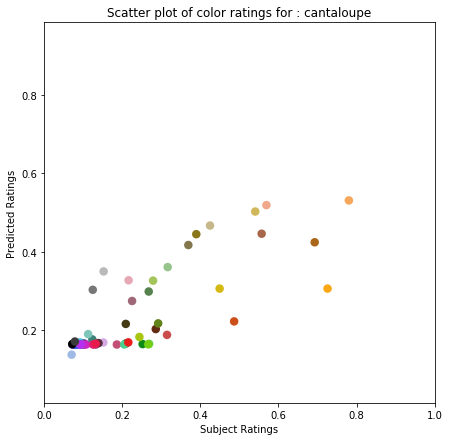

Score is : 0.42
Coefficients:  [ 0.16067195  0.25372063 -0.13759804  0.23237265]

Mean squared error: 0.0142
Variance score: 0.42
The true squared error (in color ratings) for left out fruit grapefruit is: 0.6428

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8355
p-value 0.0000


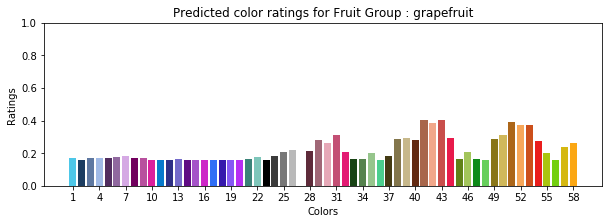

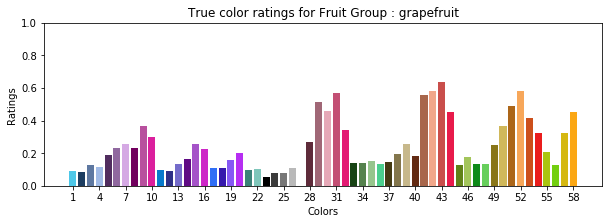

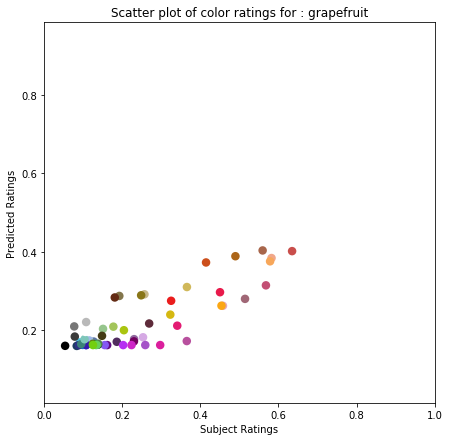

Score is : 0.15
Coefficients:  [ 0.16047563  0.2563957  -0.1516886   0.24566505]

Mean squared error: 0.0232
Variance score: 0.15
The true squared error (in color ratings) for left out fruit strawberry is: 1.2533

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4700
p-value 0.0002


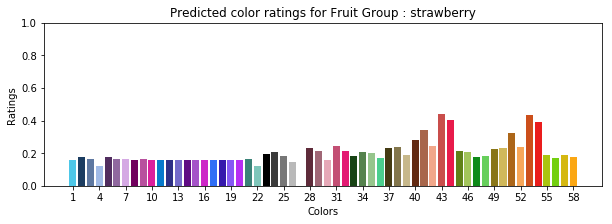

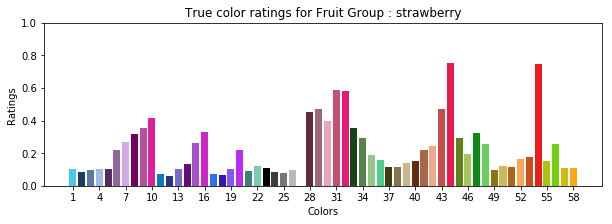

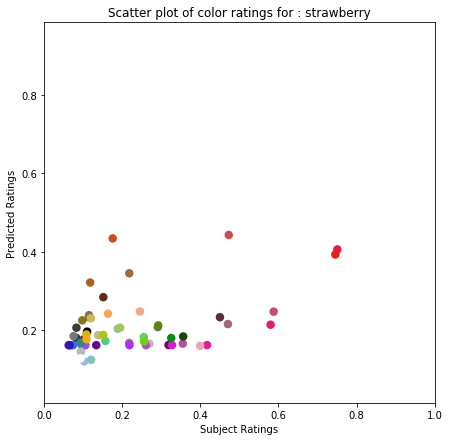

Score is : -0.07
Coefficients:  [ 0.15920905  0.29092896 -0.14361491  0.22267683]

Mean squared error: 0.0255
Variance score: -0.07
The true squared error (in color ratings) for left out fruit raspberry is: 1.1509

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4121
p-value 0.0013


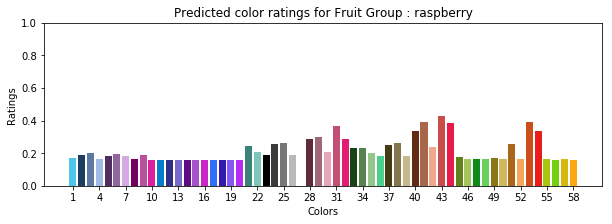

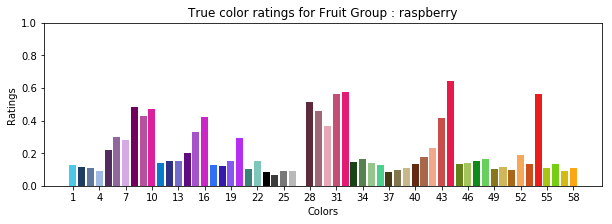

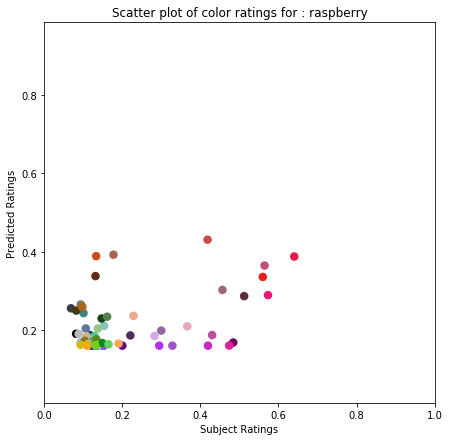

Score is : 0.05
Coefficients:  [ 0.16055712  0.26041575 -0.14546928  0.24787688]

Mean squared error: 0.0402
Variance score: 0.05
The true squared error (in color ratings) for left out fruit blueberry is: 2.2636

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.3268
p-value 0.0123


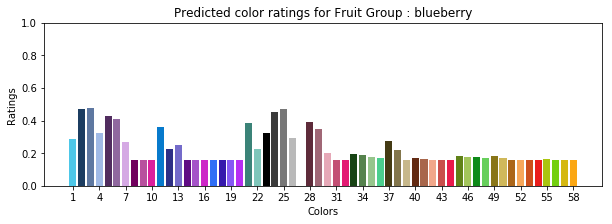

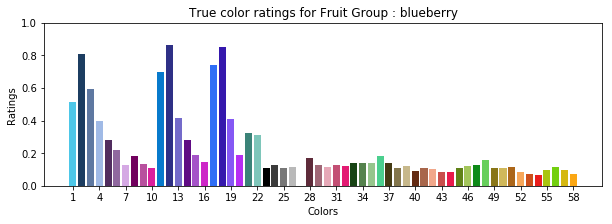

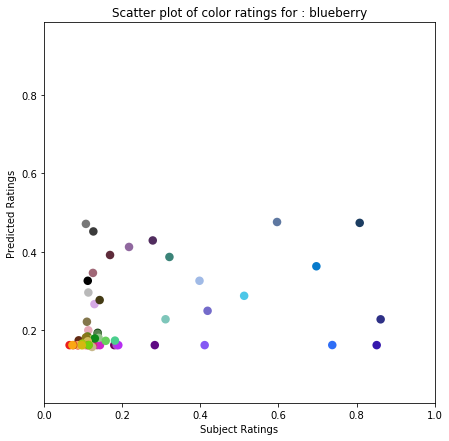

Score is : 0.18
Coefficients:  [ 0.16479247  0.27715256 -0.13937288  0.21519907]

Mean squared error: 0.0293
Variance score: 0.18
The true squared error (in color ratings) for left out fruit avocado is: 1.6390

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4952
p-value 0.0001


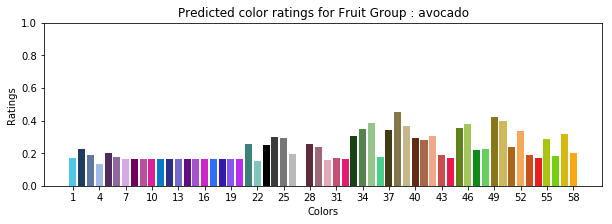

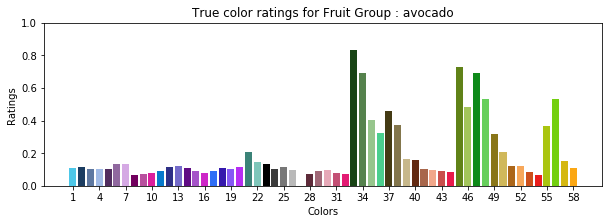

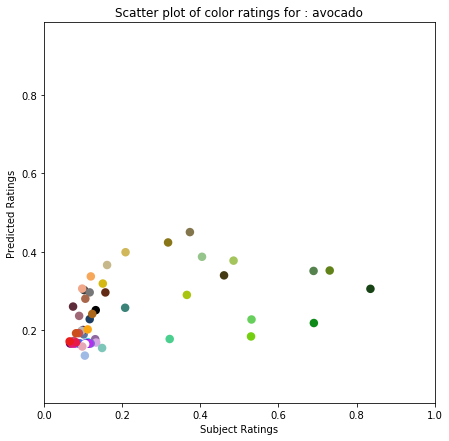

Score is : 0.47
Coefficients:  [ 0.16559424  0.22160809 -0.15783271  0.25931964]

Mean squared error: 0.0197
Variance score: 0.47
The true squared error (in color ratings) for left out fruit orange is: 1.0396

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8755
p-value 0.0000


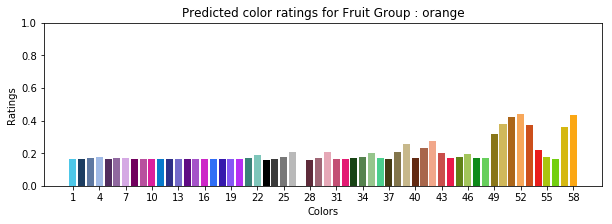

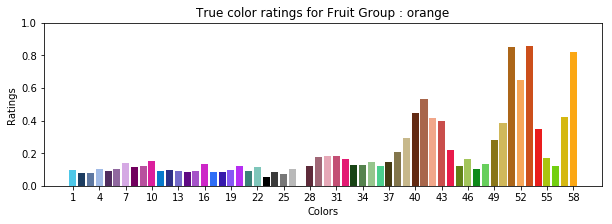

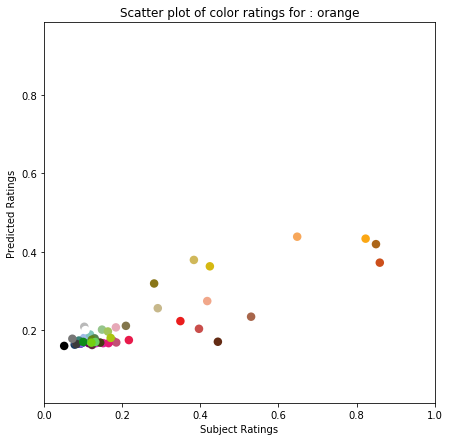

Score is : 0.46
Coefficients:  [ 0.16641432  0.28774485 -0.14411496  0.19411474]

Mean squared error: 0.0238
Variance score: 0.46
The true squared error (in color ratings) for left out fruit lime is: 1.2670

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7520
p-value 0.0000


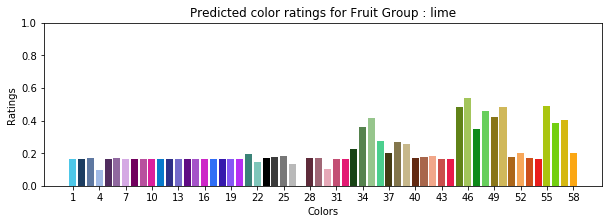

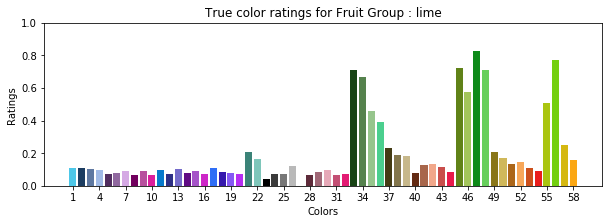

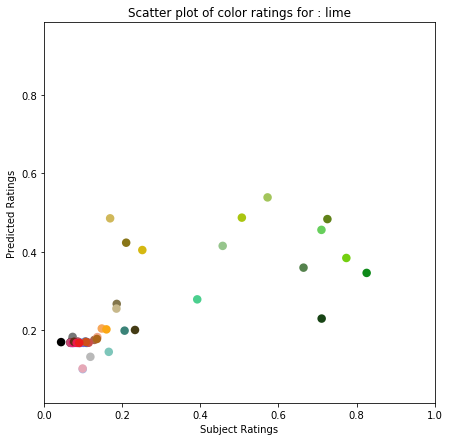

Score is : 0.67
Coefficients:  [ 0.16652029  0.26848698 -0.15574663  0.22291265]

Mean squared error: 0.0085
Variance score: 0.67
The true squared error (in color ratings) for left out fruit lemon is: 0.4354

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8731
p-value 0.0000


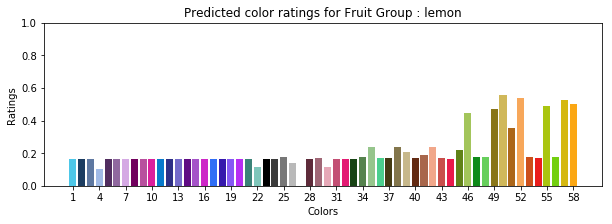

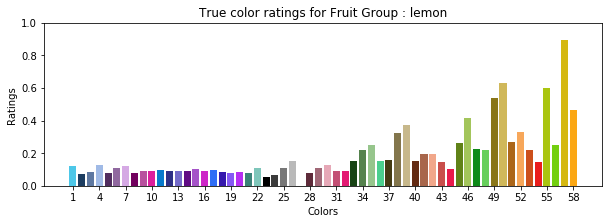

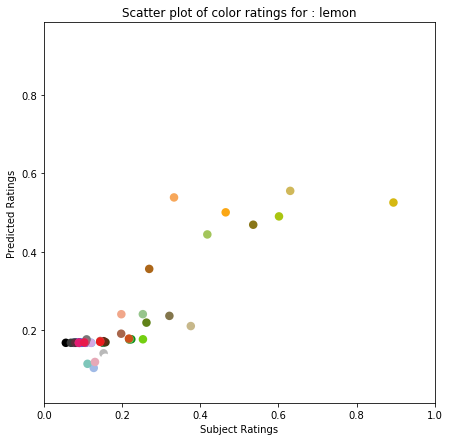

In [10]:
# Sparse features from Analysis I
minErrFeature1 = (4, 24, 29)
errSph, corrSph,  win0_m1, win1_m1, win2_m1  = getRatings(minErrFeature1)

In [11]:
win0_m1

[0.8572244679830343,
 0.20164984033453426,
 0.757197230608976,
 0.7933257452511517,
 0.8354634037685512,
 0.4700312739161002,
 0.41211043304632666,
 0.32684843350257914,
 0.4952244015280023,
 0.875480688960966,
 0.752047099653398,
 0.8731247543300519]

In [12]:
corrSph

[0.8572244679830343,
 0.20164984033453426,
 0.757197230608976,
 0.7933257452511517,
 0.8354634037685512,
 0.4700312739161002,
 0.41211043304632666,
 0.32684843350257914,
 0.4952244015280023,
 0.875480688960966,
 0.752047099653398,
 0.8731247543300519]

# Regression on top 3 spherical + cyindrical features

Score is : 0.64
Coefficients:  [0.13509019 0.05596026 0.13762729 0.25223576]

Mean squared error: 0.0121
Variance score: 0.64
The true squared error (in color ratings) for left out fruit mango is: 0.6235

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9112
p-value 0.0000


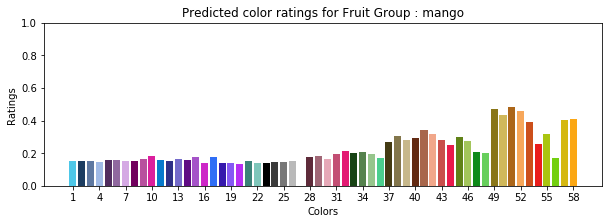

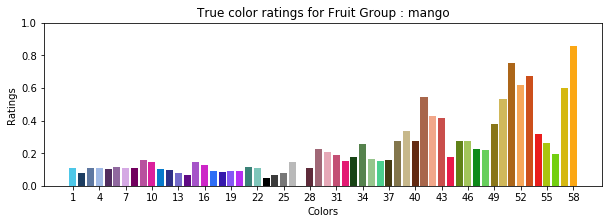

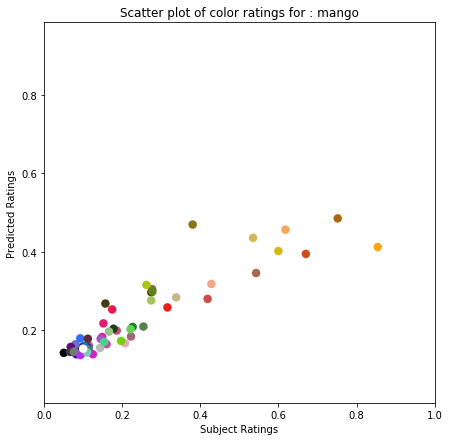

Score is : 0.03
Coefficients:  [0.12787811 0.11877771 0.13052674 0.21643487]

Mean squared error: 0.0357
Variance score: 0.03
The true squared error (in color ratings) for left out fruit watermelon is: 1.9408

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.3682
p-value 0.0045


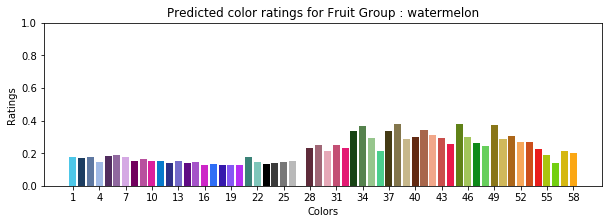

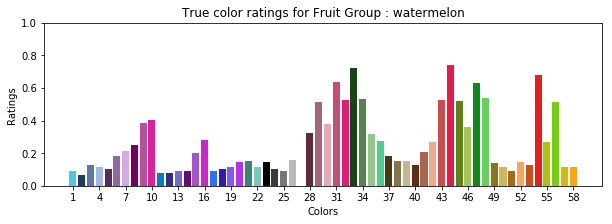

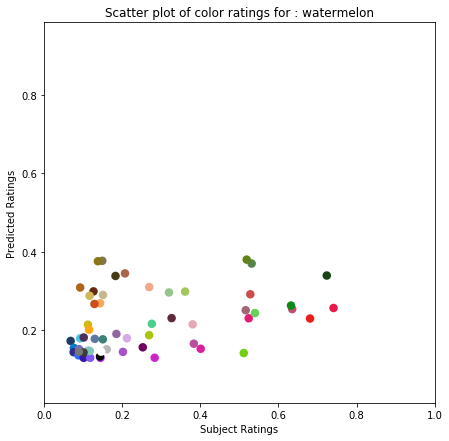

Score is : 0.59
Coefficients:  [0.13240603 0.05863625 0.18857507 0.22877034]

Mean squared error: 0.0083
Variance score: 0.59
The true squared error (in color ratings) for left out fruit honeydew is: 0.4039

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8103
p-value 0.0000


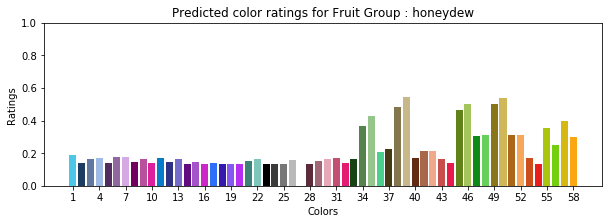

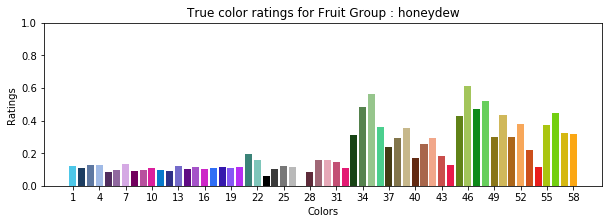

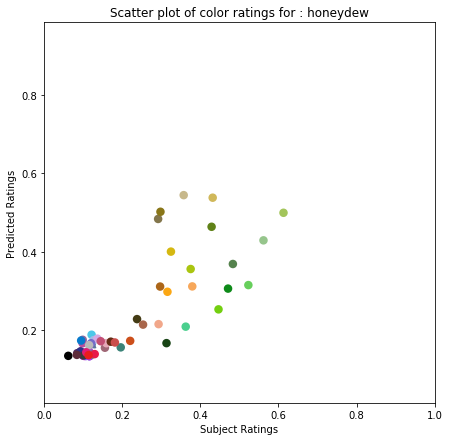

Score is : 0.62
Coefficients:  [0.13252353 0.07273227 0.15514044 0.234486  ]

Mean squared error: 0.0118
Variance score: 0.62
The true squared error (in color ratings) for left out fruit cantaloupe is: 0.5411

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8502
p-value 0.0000


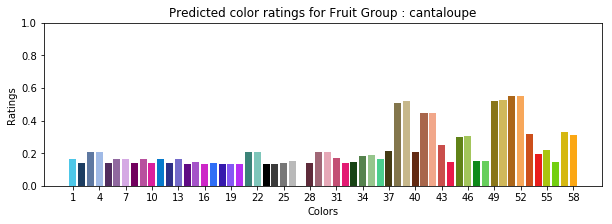

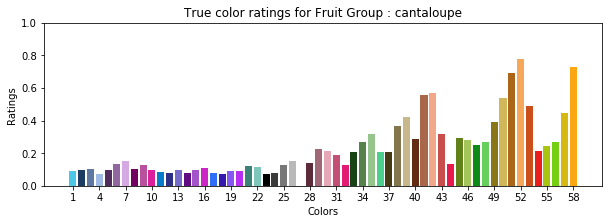

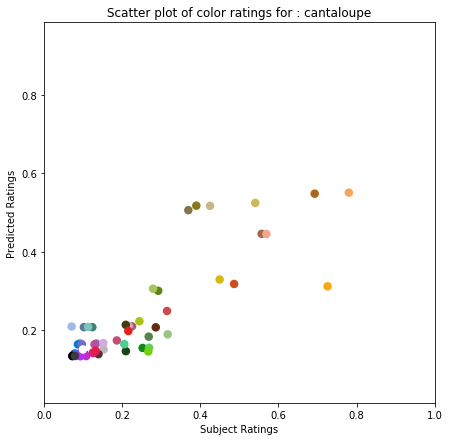

Score is : 0.45
Coefficients:  [0.13070104 0.05077731 0.18528922 0.23864948]

Mean squared error: 0.0133
Variance score: 0.45
The true squared error (in color ratings) for left out fruit grapefruit is: 0.5058

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8264
p-value 0.0000


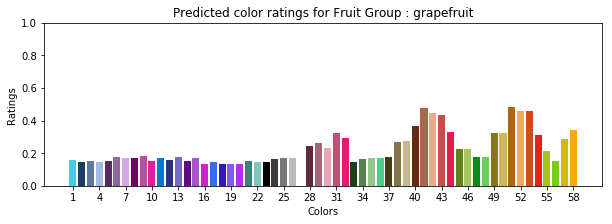

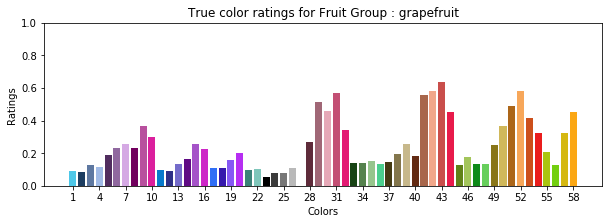

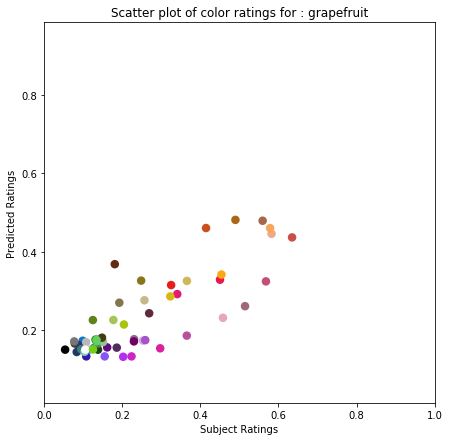

Score is : 0.19
Coefficients:  [0.13087486 0.07972432 0.14490945 0.24406592]

Mean squared error: 0.0220
Variance score: 0.19
The true squared error (in color ratings) for left out fruit strawberry is: 1.1973

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4993
p-value 0.0001


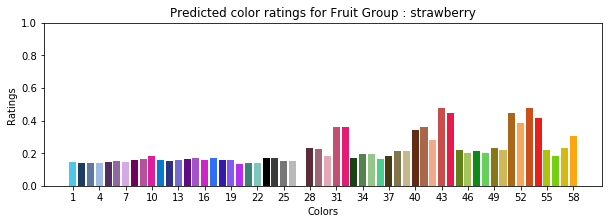

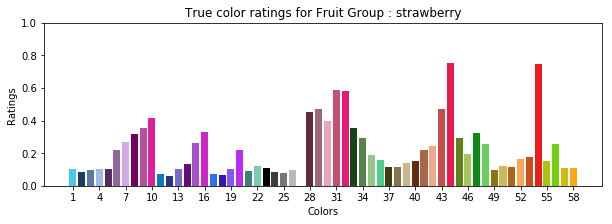

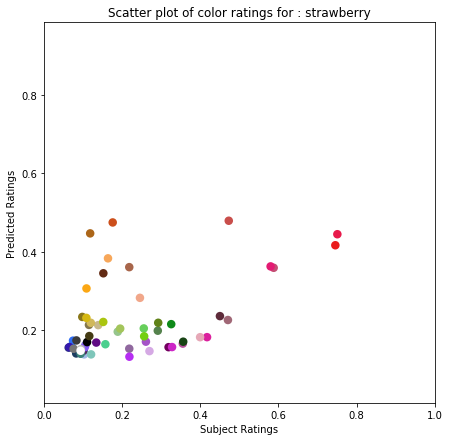

Score is : 0.06
Coefficients:  [0.12952012 0.10480002 0.13793676 0.23405213]

Mean squared error: 0.0223
Variance score: 0.06
The true squared error (in color ratings) for left out fruit raspberry is: 0.9789

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5440
p-value 0.0000


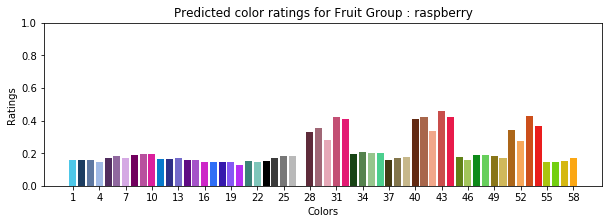

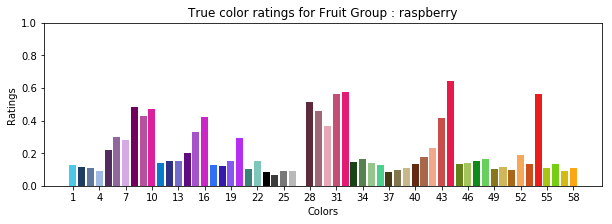

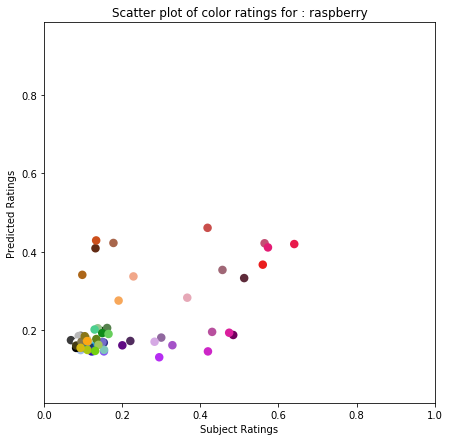

Score is : 0.28
Coefficients:  [0.1299905  0.06578502 0.15531149 0.23886908]

Mean squared error: 0.0307
Variance score: 0.28
The true squared error (in color ratings) for left out fruit blueberry is: 1.7334

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6323
p-value 0.0000


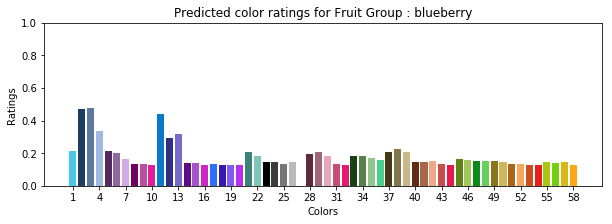

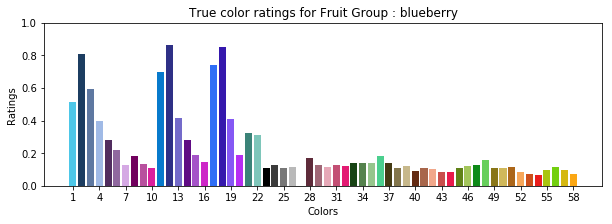

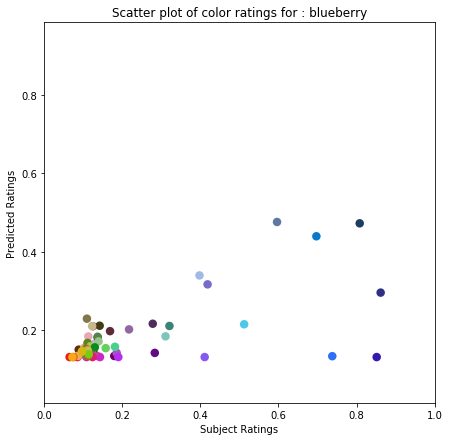

Score is : 0.32
Coefficients:  [0.1348414  0.10124064 0.15460995 0.20581521]

Mean squared error: 0.0245
Variance score: 0.32
The true squared error (in color ratings) for left out fruit avocado is: 1.3482

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6125
p-value 0.0000


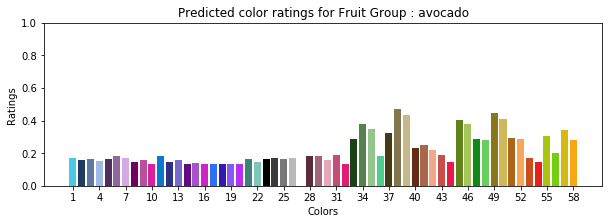

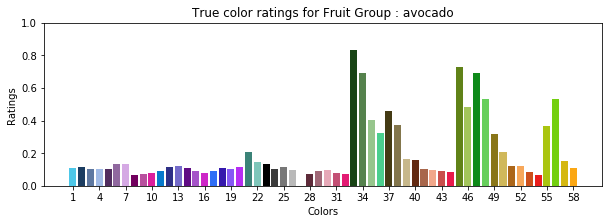

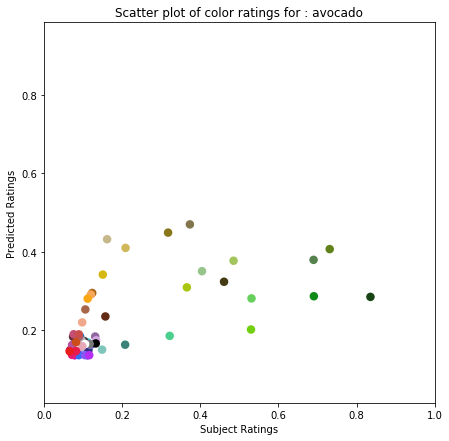

Score is : 0.61
Coefficients:  [0.13560942 0.11841691 0.11408571 0.21293783]

Mean squared error: 0.0147
Variance score: 0.61
The true squared error (in color ratings) for left out fruit orange is: 0.6803

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8859
p-value 0.0000


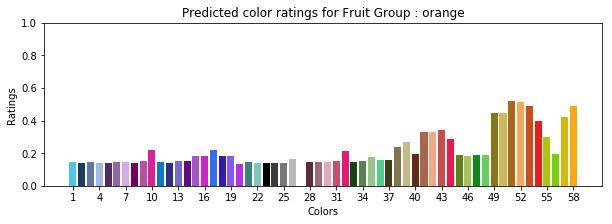

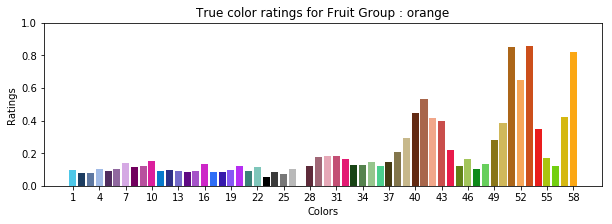

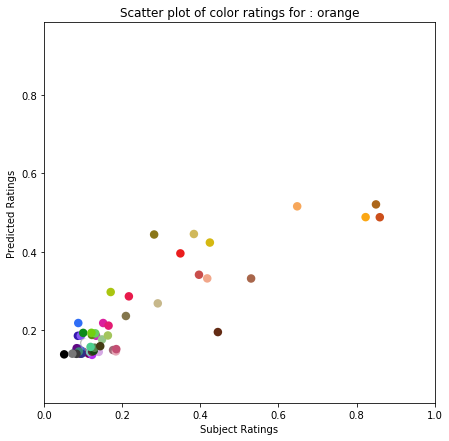

Score is : 0.54
Coefficients:  [0.13691798 0.1284949  0.11193728 0.20831251]

Mean squared error: 0.0202
Variance score: 0.54
The true squared error (in color ratings) for left out fruit lime is: 1.0904

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7893
p-value 0.0000


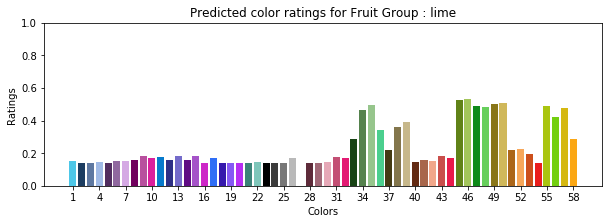

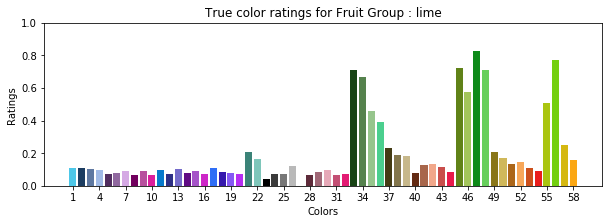

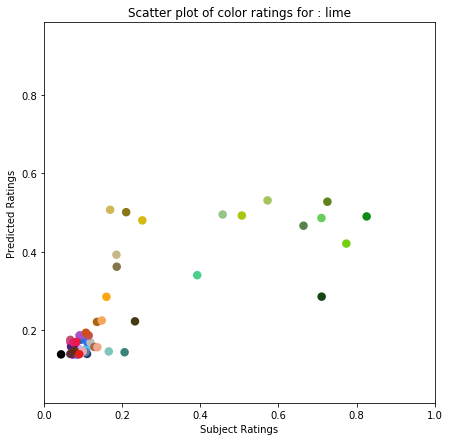

Score is : 0.64
Coefficients:  [0.13506585 0.11723016 0.11166236 0.22968707]

Mean squared error: 0.0094
Variance score: 0.64
The true squared error (in color ratings) for left out fruit lemon is: 0.4839

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8579
p-value 0.0000


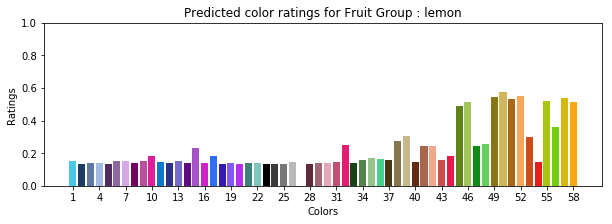

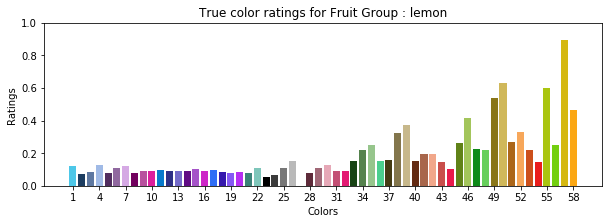

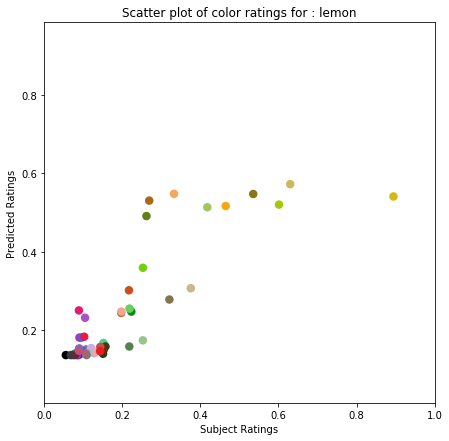

In [13]:
# Sparse features from Analysis II
minErrFeature2 = (54, 78, 179)
errSphCyl, corrSphCyl, win0_m2, win1_m2, win2_m2 = getRatings(minErrFeature2)

# Regression on top 3 Spherical + Cylindrical + Categorical

Score is : 0.63
Coefficients:  [0.13036373 0.01014357 0.23906394 0.36359293]

Mean squared error: 0.0124
Variance score: 0.63
The true squared error (in color ratings) for left out fruit mango is: 0.5945

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9291
p-value 0.0000


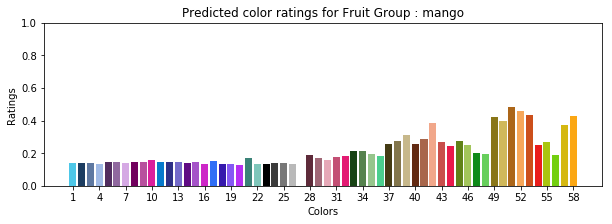

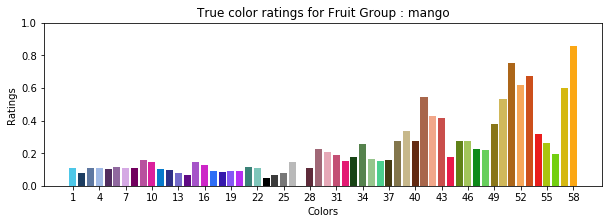

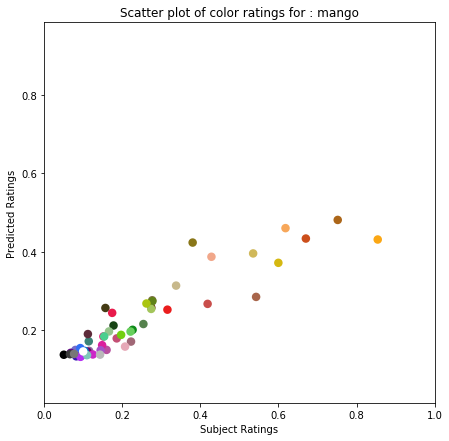

Score is : 0.17
Coefficients:  [0.12455235 0.0629038  0.21231329 0.35702236]

Mean squared error: 0.0304
Variance score: 0.17
The true squared error (in color ratings) for left out fruit watermelon is: 1.5571

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5418
p-value 0.0000


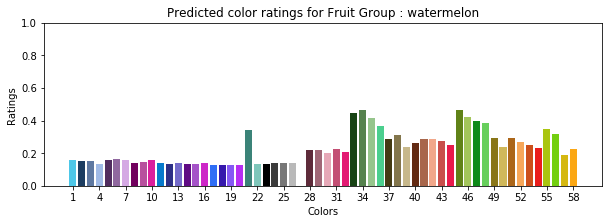

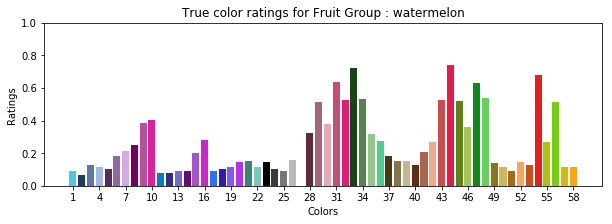

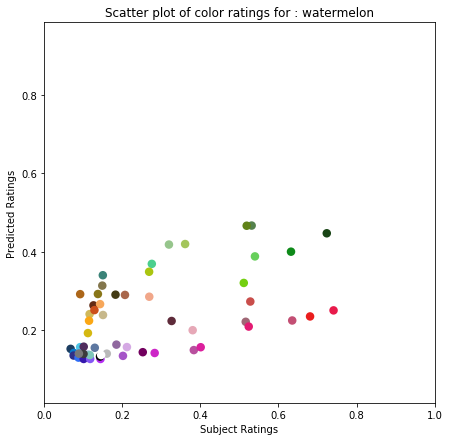

Score is : 0.75
Coefficients:  [0.12897215 0.04413642 0.22408733 0.36020263]

Mean squared error: 0.0049
Variance score: 0.75
The true squared error (in color ratings) for left out fruit honeydew is: 0.2023

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9122
p-value 0.0000


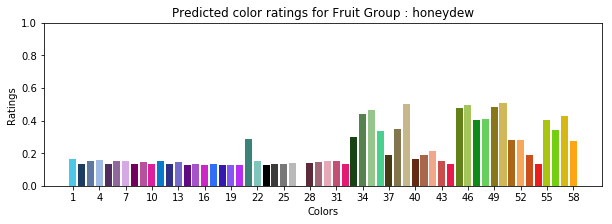

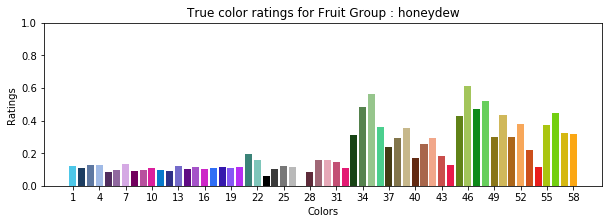

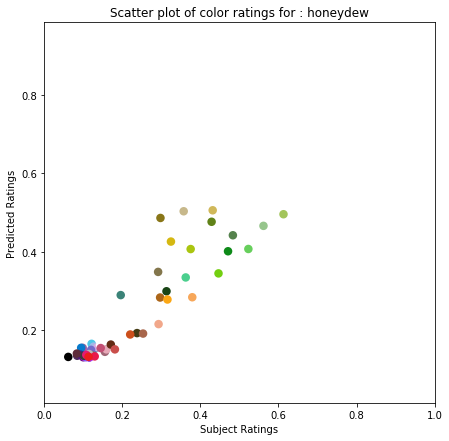

Score is : 0.69
Coefficients:  [0.12831153 0.03669545 0.22277185 0.36155081]

Mean squared error: 0.0097
Variance score: 0.69
The true squared error (in color ratings) for left out fruit cantaloupe is: 0.3936

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9174
p-value 0.0000


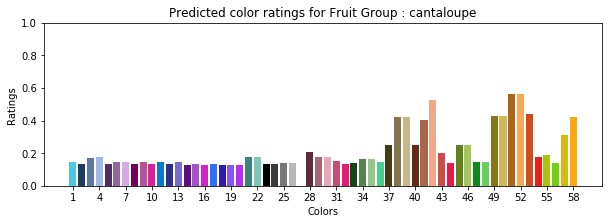

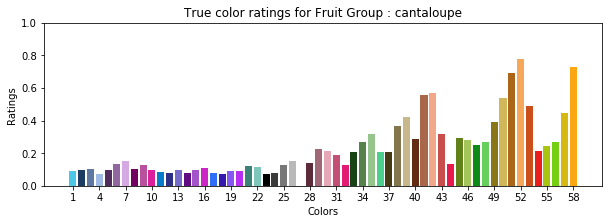

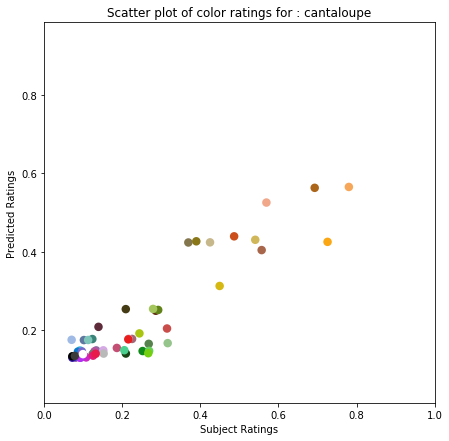

Score is : 0.41
Coefficients:  [0.12577069 0.02539878 0.23610503 0.37209285]

Mean squared error: 0.0144
Variance score: 0.41
The true squared error (in color ratings) for left out fruit grapefruit is: 0.5424

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8279
p-value 0.0000


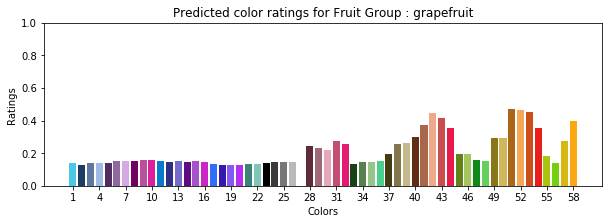

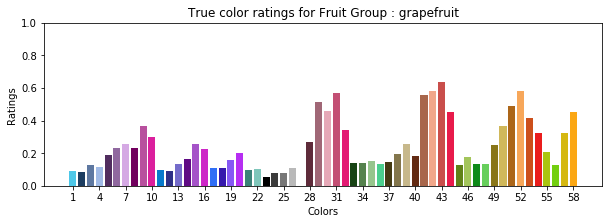

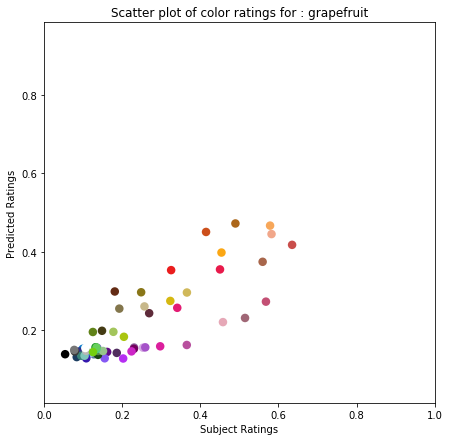

Score is : 0.30
Coefficients:  [0.12602845 0.03922178 0.23564227 0.35364876]

Mean squared error: 0.0190
Variance score: 0.30
The true squared error (in color ratings) for left out fruit strawberry is: 1.0137

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6075
p-value 0.0000


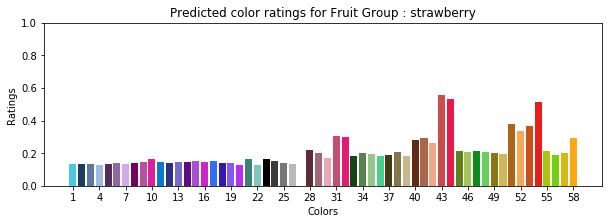

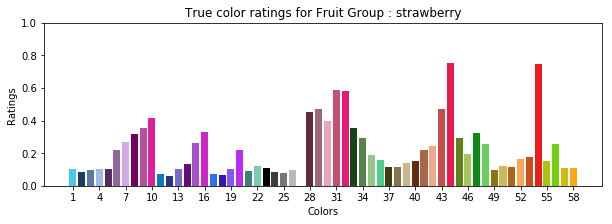

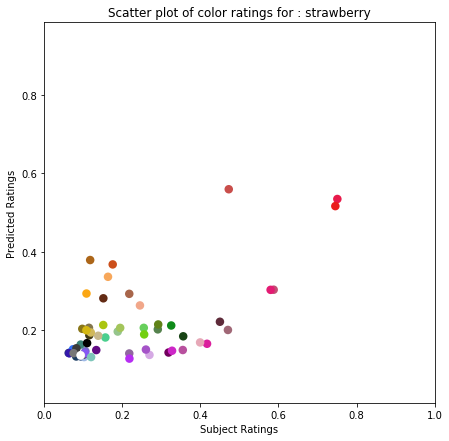

Score is : 0.05
Coefficients:  [0.12534595 0.05534083 0.21855088 0.37174362]

Mean squared error: 0.0227
Variance score: 0.05
The true squared error (in color ratings) for left out fruit raspberry is: 0.8882

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5991
p-value 0.0000


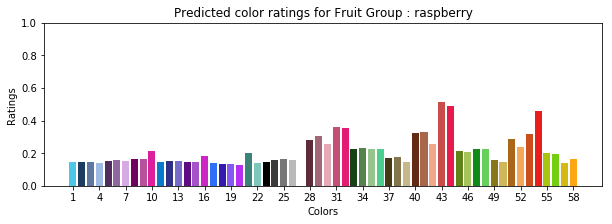

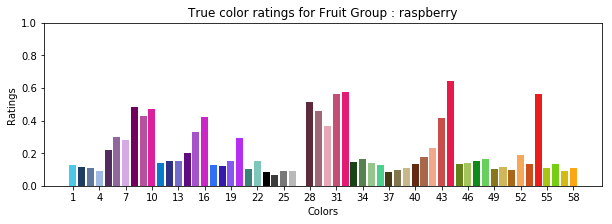

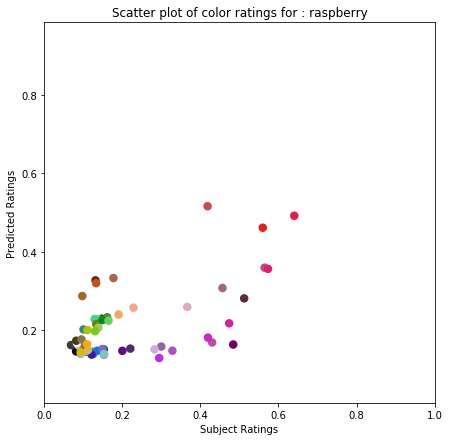

Score is : 0.70
Coefficients:  [0.12915681 0.04895353 0.22854932 0.3298813 ]

Mean squared error: 0.0127
Variance score: 0.70
The true squared error (in color ratings) for left out fruit blueberry is: 0.6997

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8657
p-value 0.0000


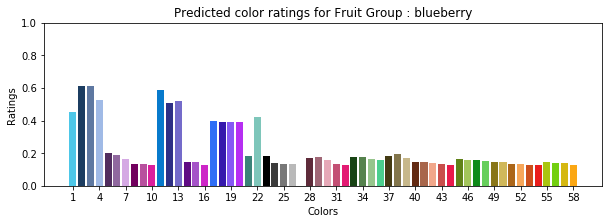

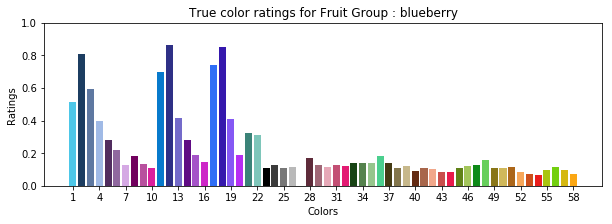

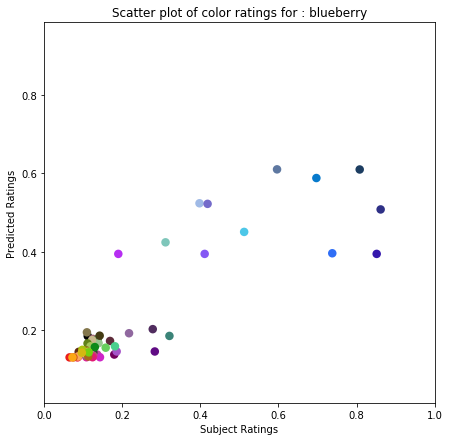

Score is : 0.43
Coefficients:  [0.13095183 0.06318167 0.20442141 0.34992564]

Mean squared error: 0.0205
Variance score: 0.43
The true squared error (in color ratings) for left out fruit avocado is: 1.0912

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7297
p-value 0.0000


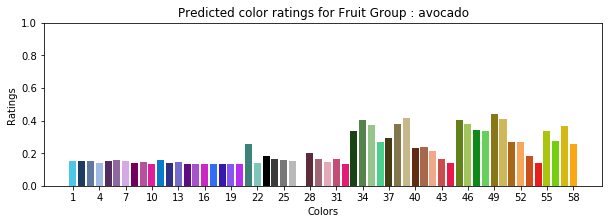

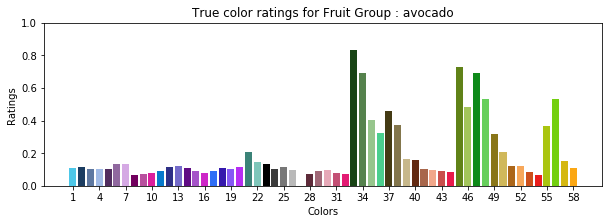

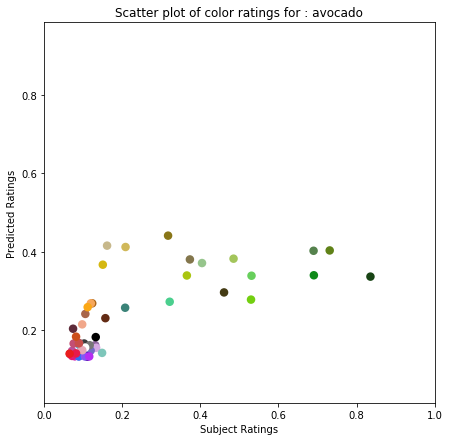

Score is : 0.76
Coefficients:  [0.13058135 0.03110483 0.23043019 0.35069774]

Mean squared error: 0.0089
Variance score: 0.76
The true squared error (in color ratings) for left out fruit orange is: 0.4405

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9198
p-value 0.0000


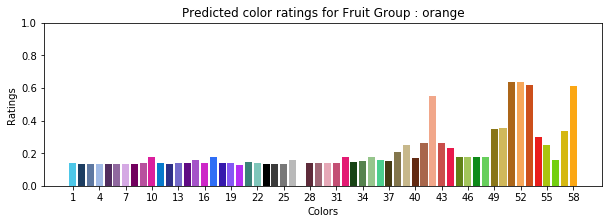

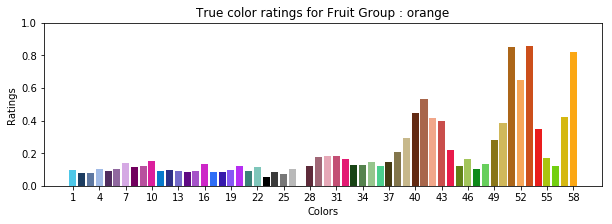

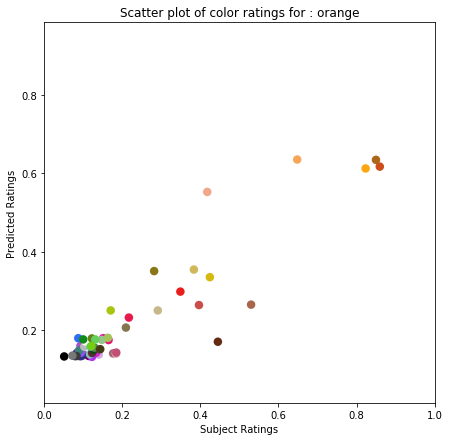

Score is : 0.71
Coefficients:  [0.13144468 0.05381951 0.22029698 0.36090618]

Mean squared error: 0.0127
Variance score: 0.71
The true squared error (in color ratings) for left out fruit lime is: 0.5519

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9236
p-value 0.0000


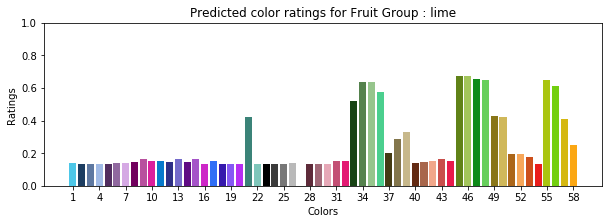

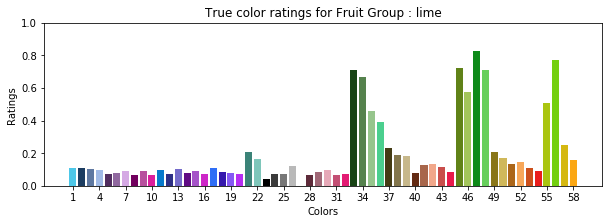

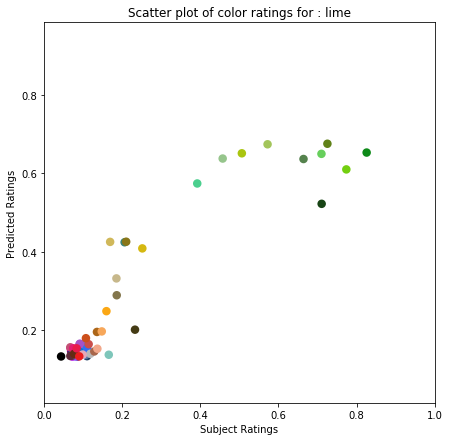

Score is : 0.77
Coefficients:  [0.13050108 0.04150795 0.22289726 0.36339616]

Mean squared error: 0.0061
Variance score: 0.77
The true squared error (in color ratings) for left out fruit lemon is: 0.3170

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9006
p-value 0.0000


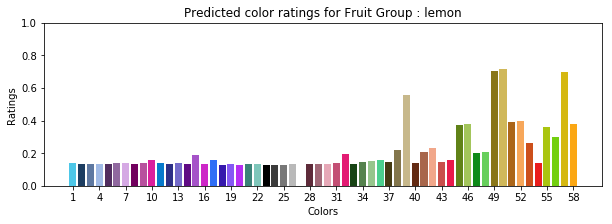

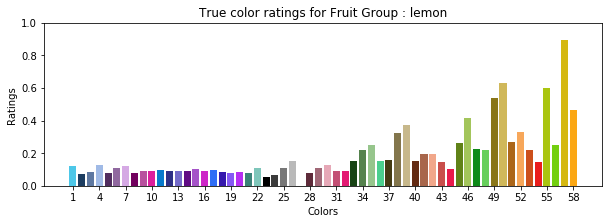

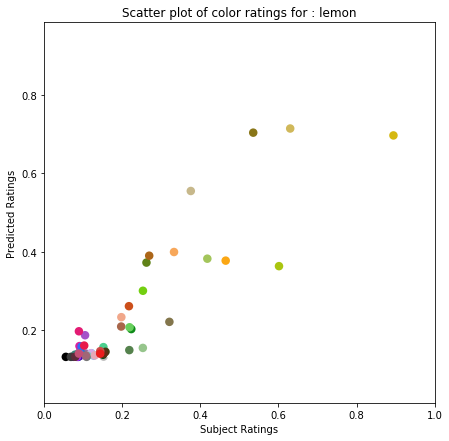

In [14]:
# Sparse features from Analysis III
minErrFeature3 = (54, 179, 180)
errSphCylCat, corrSphCylCat, win0_m3, win1_m3, win2_m3 = getRatings(minErrFeature3)

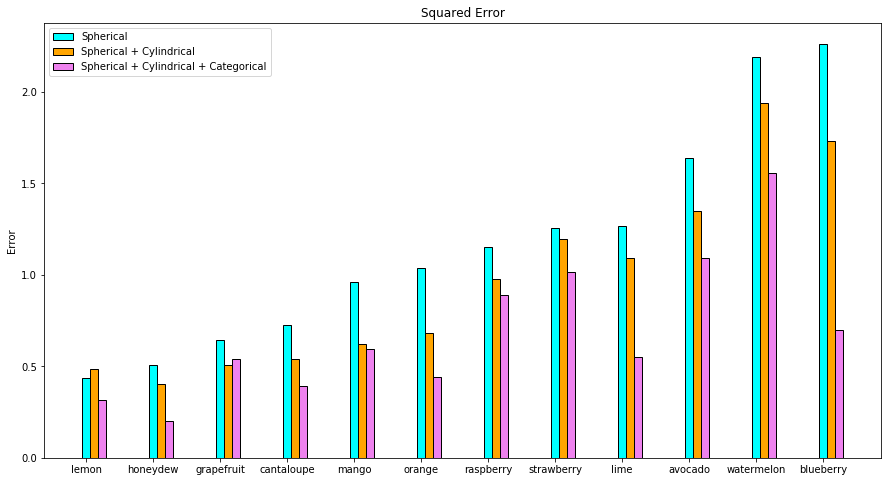

In [15]:
temp  = errSph[:]
indices = np.argsort(temp)
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize=(15,8))
plt.bar(r1,sorted(errSph),width = barWidth, color = 'cyan', edgecolor = 'black',label='Spherical')
plt.bar(r2,[errSphCyl[t] for t in indices],width = barWidth, color = 'orange', edgecolor = 'black',label='Spherical + Cylindrical')
plt.bar(r3,[errSphCylCat[t] for t in indices],width = barWidth, color = 'violet', edgecolor = 'black',label='Spherical + Cylindrical + Categorical')
plt.xticks(range(1,121,10),label)
plt.title("Squared Error")
plt.ylabel('Error')
plt.legend()
#plt.savefig('ErrWithIncreasingRadial.pdf')
plt.show()

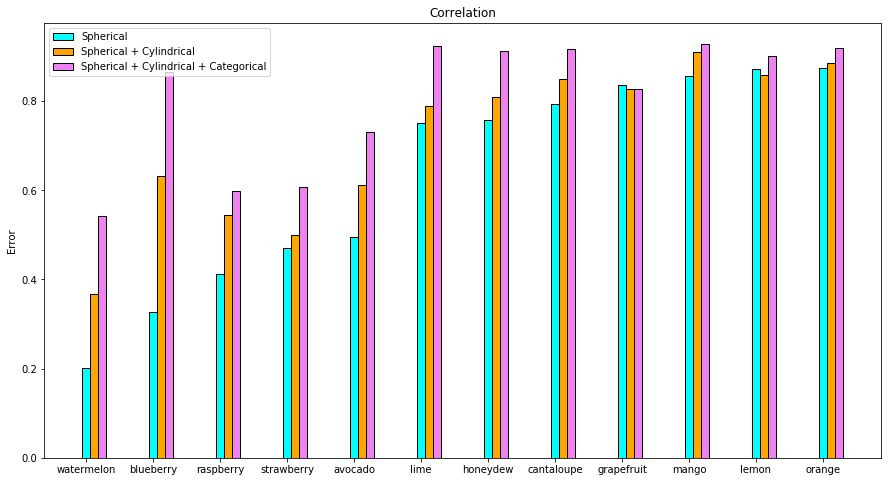

In [16]:
temp  = corrSph[:]
indices = np.argsort(temp)
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
plt.close('all')
#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize=(15,8))
plt.bar(r1,sorted(corrSph),width = barWidth, color = 'cyan', edgecolor = 'black',label='Spherical')
plt.bar(r2,[corrSphCyl[t] for t in indices],width = barWidth, color = 'orange', edgecolor = 'black',label='Spherical + Cylindrical')
plt.bar(r3,[corrSphCylCat[t] for t in indices],width = barWidth, color = 'violet', edgecolor = 'black',label='Spherical + Cylindrical + Categorical')
plt.xticks(range(1,121,10),label)
plt.title("Correlation")
plt.ylabel('Error')
plt.legend()
#plt.savefig('CorrWithIncreasingRadial.eps')
plt.show()

In [17]:
# # For plots of correlations
# _, _, win0_m3, win1_m3, win2_m3 = getRatings(minErrFeature3)

# Figure2: Scatter plots for the best model

In [18]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 9})
def createScatterPlots(indices, win0, win1, win2,model_num):
    print("----------------------- Creating plots for Model ---------------",model_num)
    # print(indices)
    # print(win0)
    
    k = 1
    plt.close('all')

    plt.subplots(3,4,figsize=(10,10))
    for i in range(len(indices)-1,-1,-1):
        # Scatter plot

        arg = indices[i]
        trueRating = win1[arg]
        avg_pred = win2[arg]

        ax = plt.subplot(3,4,k,aspect='equal') #plt.figure(figsize=(7,7))
        #ax = f.add_subplot(3,4,k)
        plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
        if k == 1 or k == 5 or k == 9:
            plt.ylabel('Mean Predicted Rating')
        plt.xlabel('Mean Rating')
        s = allConcepts[arg]+"( %.2f )" %win0[arg]
        #print(s)
        plt.title(s)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.yticks([0,0.5,1])
        plt.xticks([0,0.5,1])
        plt.tick_params(direction='in')
        plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--')
        k = k+1
    #plotName = "ScatterPlot_Model_"+str(model_num)+".pdf"
    #plt.savefig(plotName)
    plt.show()
    
    

----------------------- Creating plots for Model --------------- 1


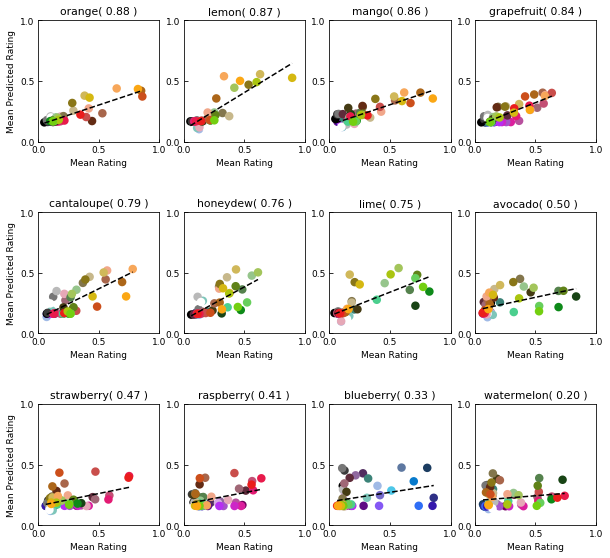

----------------------- Creating plots for Model --------------- 2


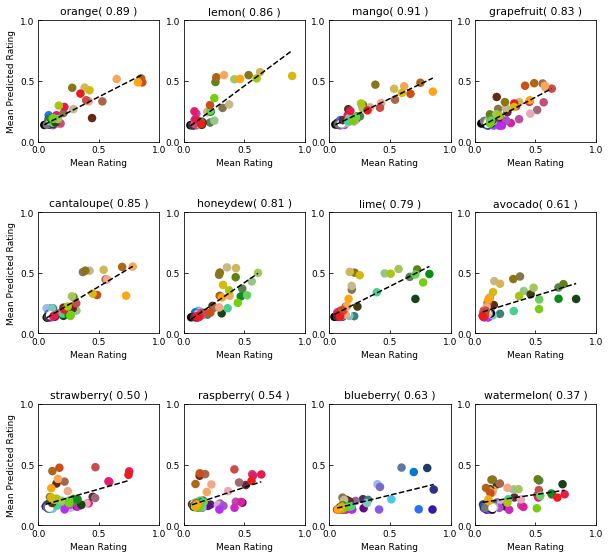

----------------------- Creating plots for Model --------------- 3


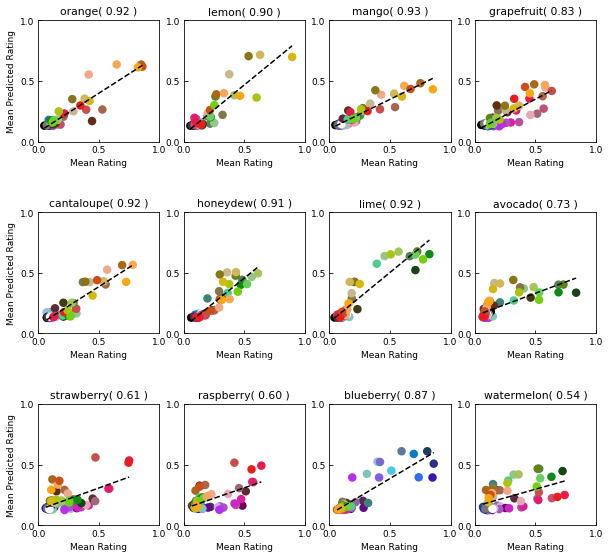

In [19]:
indices = np.argsort(win0_m1) # Want in the order of model 1 correlations
createScatterPlots(indices, win0_m1, win1_m1, win2_m1,1)
createScatterPlots(indices, win0_m2, win1_m2, win2_m2,2)
createScatterPlots(indices,win0_m3, win1_m3, win2_m3,3)

In [20]:
# indices = np.argsort(win0_m3)
# print(indices)
# print(win0_m3)

In [21]:
# k = 1
# plt.close('all')
# import matplotlib as mpl
# mpl.rcParams.update({'font.size': 9})
# plt.subplots(3,4,figsize=(10,10))
# for i in range(len(indices)-1,-1,-1):
#     # Scatter plot
    
#     arg = indices[i]
#     trueRating = win1_m3[arg]
#     avg_pred = win2_m3[arg]
    
#     ax = plt.subplot(3,4,k,aspect='equal') #plt.figure(figsize=(7,7))
#     #ax = f.add_subplot(3,4,k)
#     plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
#     if k == 1 or k == 5 or k == 9:
#         plt.ylabel('Mean Predicted Rating')
#     plt.xlabel('Mean Rating')
#     s = allConcepts[arg]+"( %.2f )" %win0_m3[arg]
#     #print(s)
#     plt.title(s)
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.yticks([0,0.5,1])
#     plt.xticks([0,0.5,1])
#     plt.tick_params(direction='in')
#     plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--')
#     k = k+1
# #plt.savefig('ScatterPlotBestModel.pdf')
# plt.show()

In [22]:
# trueCorr, pval = stats.pearsonr(pred, true)
# print("\nPearson’s correlation coefficient (between all true ratings and all avg predicted ratings) is %.4f" %trueCorr)
# print("p-value %.4f" %pval)

In [23]:
cor_m3,_ = stats.pearsonr(np.array(win2_m3).flatten(), np.array(win1_m3).flatten())
cor_m2,_ = stats.pearsonr(np.array(win2_m2).flatten(), np.array(win1_m2).flatten())
cor_m1,_ = stats.pearsonr(np.array(win2_m1).flatten(), np.array(win1_m1).flatten())

In [24]:
print("For TOP 5")
print("model 1:", cor_m1)
print("model 2:",cor_m2)
print("model :3",cor_m3)

For TOP 5
model 1: 0.622532315109387
model 2: 0.704744862244575
model :3 0.8018949231136535


In [25]:
cor_m1

0.622532315109387

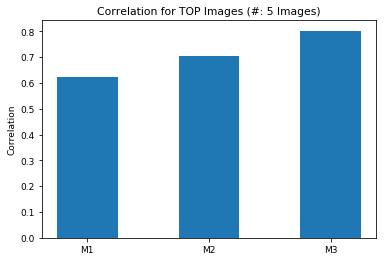

In [26]:
barWidth = 0.5
plt.bar(range(1,4),[cor_m1, cor_m2, cor_m3], width = barWidth)
plt.xticks(range(1,4),['M1','M2','M3'])
plt.title("Correlation for TOP Images (#: 5 Images)")
plt.ylabel('Correlation')
plt.show()

# Figure 3: Error and Correlation stem plots for #Images: 5

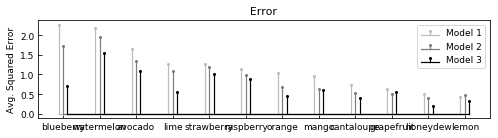

In [27]:
plt.close('all')
temp  = errSph[:]
indices = np.flipud(np.argsort(temp)) # Sort and get indices and reverse order
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
# fig = plt.figure(figsize =(12,6))
# #linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
# mline1 = plt.stem(r1,sorted(errSph)[::-1], linefmt='-',label='Model 1')
# plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=2)

fig = plt.figure(figsize =(7,2))
#linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
mline1 = plt.stem(r1,sorted(errSph)[::-1], linefmt='-',label='Model 1')
plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=1.2, markersize = 2)


mline2 = plt.stem(r2,[errSphCyl[t] for t in indices],label='Model 2')
plt.setp(mline2, color=[0.486,0.486,0.486], linewidth=1.2, markersize = 2)

mline3 = plt.stem(r3,[errSphCylCat[t] for t in indices],label='Model 3')
plt.setp(mline3, color=[0,0,0], linewidth=1.2, markersize = 2)

plt.xticks(r2,label)
plt.tick_params(direction='in')
plt.title("Error")
plt.ylabel('Avg. Squared Error')
plt.legend()
plt.tight_layout()
plt.savefig('ErrorTop5_AllModels.pdf')
plt.show()

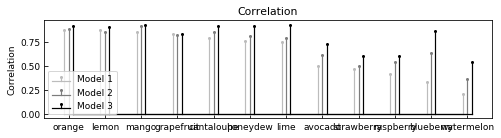

In [28]:
plt.close('all')
temp  = corrSph[:]
indices = np.flipud(np.argsort(temp)) # Sort and get indices and reverse order
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

fig = plt.figure(figsize =(7,2))
#linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
mline1 = plt.stem(r1,sorted(corrSph)[::-1], linefmt='-',label='Model 1')
plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=1.2, markersize = 2)

# fig = plt.figure(figsize =(12,6))
# #linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
# mline1 = plt.stem(r1,sorted(corrSph)[::-1], linefmt='-',label='Model 1')
# plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=2)

mline2 = plt.stem(r2,[corrSphCyl[t] for t in indices],label='Model 2')
plt.setp(mline2, color=[0.486,0.486,0.486], linewidth=1.2, markersize = 2)

mline3 = plt.stem(r3,[corrSphCylCat[t] for t in indices],label='Model 3')
plt.setp(mline3, color=[0,0,0], linewidth=1.2, markersize = 2)

plt.xticks(r2,label)
plt.tick_params(direction='in')
plt.title("Correlation")
plt.ylabel('Correlation')
plt.legend()
plt.tight_layout() 
plt.savefig('CorrelationTop5_AllModels.pdf')
plt.show()